In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import warnings

In [278]:
warnings.filterwarnings("ignore")

In [307]:
CD = pd.read_csv('~/Desktop/Metaphlan4_MGX_CD.csv').set_index('Abundance').T
UC = pd.read_csv('~/Desktop/Metaphlan4_MGX_UC.csv').set_index('Abundance').T
Control = pd.read_csv('~/Desktop/Metaphlan4_MGX_Control.csv').set_index('Abundance').T
# CD['diagnosis'] = 'CD'
# UC['diagnosis'] = 'UC'
# Control['diagnosis'] = 'Control'
IBDMDB_Metaphlan4 = pd.concat([CD,UC,Control])
IBD_METADATA = pd.read_csv('~/Desktop/selected_samples_MGX.csv').set_index('External ID')
IBD_METADATA

,Participant ID,fecalcal_max,Diagnosis
External ID,,,
CSM67UA2,C3001,37.17836,CD
CSM5MCVN,C3002,16.32450,CD
CSM67UBZ,C3003,14.30000,UC
CSM5MCXL,C3004,70.91411,UC
CSM5MCY8,C3005,232.60620,UC
...,...,...,...
PSM7J19N,P6017,16.78459,nonIBD
PSM6XBW3,P6018,79.82248,nonIBD
PSM7J12J,P6024,289.22620,CD


In [280]:
Lewis_metaphlan4 = pd.read_csv('~/Desktop/control_group/Lewis/Lewis.csv').set_index('Abundance').T
Lewis_METADATA = pd.read_csv('~/Desktop/control_group/Lewis/SRP057027.info.txt', delimiter = "\t").set_index('Sample')
Lewis_metaphlan4

Abundance,k__Bacteria,p__Firmicutes,p__Actinobacteria,p__Proteobacteria,p__Verrucomicrobia,p__Bacteroidetes,c__Clostridia,c__Actinobacteria,c__Erysipelotrichia,c__Bacilli,...,s__GGB2722_SGB3663,t__SGB7027,t__SGB7208,t__SGB3663,o__Rhodobacterales,f__Rhodobacteraceae,g__Paracoccus,s__Paracoccus_yeei,t__SGB14301,t__SGB10717
SAMN03469518,99.99845,94.02813,4.32422,1.05704,0.39609,0.19297,90.08550,4.22551,1.73321,1.48265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469407,99.97740,93.17970,3.16483,0.38456,0.00000,3.21165,84.88414,2.93995,0.99073,0.11909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469276,100.00000,23.45629,2.56574,2.44134,0.00000,71.53663,22.16045,2.35708,0.11489,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469589,100.00000,0.00000,0.00000,0.00000,0.00000,100.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469332,100.00000,37.24275,0.04044,0.97261,0.25031,61.49389,34.70311,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN03469350,100.00000,10.38402,0.00000,0.00000,0.00000,89.61598,1.38426,0.00000,0.00000,8.99976,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469584,100.00000,10.05810,0.11399,3.29340,0.05552,86.36508,9.11926,0.04510,0.15167,0.00325,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
SAMN03469562,100.00000,77.86724,0.47385,3.47807,5.54095,12.63988,60.42124,0.06294,16.79800,0.52505,...,0.0,0.0,0.0,0.0,0.17876,0.17876,0.17876,0.17876,0.26435,0.17876
SAMN03469536,100.00000,42.28013,0.00000,0.00000,0.96149,56.75838,37.34825,0.00000,0.42886,0.00000,...,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [308]:
# IBD_METADATA = IBD_METADATA[IBD_METADATA['Diagnosis'] == 'nonIBD']
# IBD_METADATA = IBD_METADATA.sample(20)
IBDMDB_Metaphlan4 = IBDMDB_Metaphlan4.loc[IBD_METADATA.index,:]
IBDMDB_Metaphlan4 = IBDMDB_Metaphlan4.loc[:,~IBDMDB_Metaphlan4.columns.str.startswith('t__') & ~IBDMDB_Metaphlan4.columns.str.startswith('k__')]
IBDMDB_Metaphlan4['Diagnosis'] = IBD_METADATA.Diagnosis
IBDMDB_Metaphlan4

Abundance,p__Firmicutes,p__Bacteroidetes,p__Proteobacteria,p__Actinobacteria,c__Clostridia,c__Bacteroidia,c__Negativicutes,c__Firmicutes_unclassified,c__Betaproteobacteria,c__Deltaproteobacteria,...,s__Streptococcus_dysgalactiae,s__Corynebacterium_accolens,g__GGB39918,s__GGB39918_SGB47522,g__GGB3171,s__GGB3171_SGB4185,s__Slackia_piriformis,s__Bacteroidales_bacterium_KA00251,s__Parvimonas_sp_KA00067,Diagnosis
External ID,,,,,,,,,,,,,,,,,,,,,
CSM67UA2,13.05380,77.86079,0.19580,0.00000,11.10516,77.86079,1.92969,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD
CSM5MCVN,18.76241,76.11742,5.12017,0.00000,10.46042,76.11742,8.30199,0.00000,5.10865,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD
CSM67UBZ,25.43529,74.48676,0.07795,0.00000,23.18565,74.48676,1.61346,0.00000,0.07795,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
CSM5MCXL,15.93873,78.47221,2.53297,0.03830,15.08962,78.47221,0.84585,0.00000,0.99814,0.27782,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
CSM5MCY8,16.16463,78.71581,5.08118,0.00785,14.65269,78.71581,0.89270,0.00000,0.64018,0.39798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSM7J19N,27.27891,70.89165,0.72065,0.09989,23.26381,70.89165,3.20406,0.71590,0.50561,0.10316,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,nonIBD
PSM6XBW3,76.85437,5.47352,16.85766,0.81444,59.73202,5.47352,12.41931,0.00000,0.00000,0.89484,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,nonIBD
PSM7J12J,12.52948,84.86483,2.58719,0.01850,7.12656,84.86483,5.22412,0.00000,0.03193,0.13696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD


In [309]:
IBDMDB_Metaphlan4 = IBDMDB_Metaphlan4.fillna(0)
all_zero = (IBDMDB_Metaphlan4 == 0).all()
IBDMDB_Metaphlan4 = IBDMDB_Metaphlan4.loc[:,~all_zero]
IBDMDB_Metaphlan4

Abundance,p__Firmicutes,p__Bacteroidetes,p__Proteobacteria,p__Actinobacteria,c__Clostridia,c__Bacteroidia,c__Negativicutes,c__Firmicutes_unclassified,c__Betaproteobacteria,c__Deltaproteobacteria,...,s__Clostridium_saccharogumia,s__Firmicutes_bacterium_AM41_11,s__Clostridia_unclassified_SGB13993,s__Anaeromassilibacillus_sp_An172,g__Turicimonas,s__Turicimonas_muris,g__GGB3743,s__GGB3743_SGB5086,s__Candidatus_Heritagella_gallinarum,Diagnosis
External ID,,,,,,,,,,,,,,,,,,,,,
CSM67UA2,13.05380,77.86079,0.19580,0.00000,11.10516,77.86079,1.92969,0.00000,0.00000,0.00000,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,CD
CSM5MCVN,18.76241,76.11742,5.12017,0.00000,10.46042,76.11742,8.30199,0.00000,5.10865,0.00000,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,CD
CSM67UBZ,25.43529,74.48676,0.07795,0.00000,23.18565,74.48676,1.61346,0.00000,0.07795,0.00000,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,UC
CSM5MCXL,15.93873,78.47221,2.53297,0.03830,15.08962,78.47221,0.84585,0.00000,0.99814,0.27782,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,UC
CSM5MCY8,16.16463,78.71581,5.08118,0.00785,14.65269,78.71581,0.89270,0.00000,0.64018,0.39798,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,UC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSM7J19N,27.27891,70.89165,0.72065,0.09989,23.26381,70.89165,3.20406,0.71590,0.50561,0.10316,...,0.00535,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,nonIBD
PSM6XBW3,76.85437,5.47352,16.85766,0.81444,59.73202,5.47352,12.41931,0.00000,0.00000,0.89484,...,0.00000,0.0,0.0,0.47414,0.0,0.0,0.40769,0.40769,4.11132,nonIBD
PSM7J12J,12.52948,84.86483,2.58719,0.01850,7.12656,84.86483,5.22412,0.00000,0.03193,0.13696,...,0.00000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,CD


In [283]:
Lewis_METADATA.loc[Lewis_METADATA['Treatment'].isnull(), 'Diagnosis'] = 1
Lewis_METADATA.loc[Lewis_METADATA['Treatment'].notnull(), 'Diagnosis'] = 0
select_sample_L = Lewis_METADATA.groupby(['Subject']).agg({'Diagnosis': 'first','sample_accession':'first'})
select_sample_L = select_sample_L[~select_sample_L.sample_accession.isnull()]
select_sample_L.set_index('sample_accession', inplace=True)

Lewis_metaphlan4 = Lewis_metaphlan4.loc[select_sample_L.index,:]
Lewis_metaphlan4 = Lewis_metaphlan4.loc[:,~Lewis_metaphlan4.columns.str.startswith('t__') & ~Lewis_metaphlan4.columns.str.startswith('k__')]
Lewis_metaphlan4['Diagnosis'] = select_sample_L.Diagnosis
Lewis_metaphlan4

Abundance,p__Firmicutes,p__Actinobacteria,p__Proteobacteria,p__Verrucomicrobia,p__Bacteroidetes,c__Clostridia,c__Actinobacteria,c__Erysipelotrichia,c__Bacilli,c__Betaproteobacteria,...,g__Secundilactobacillus,g__GGB2722,s__Lactobacillus_acetotolerans,s__Secundilactobacillus_silagei,s__GGB2722_SGB3663,o__Rhodobacterales,f__Rhodobacteraceae,g__Paracoccus,s__Paracoccus_yeei,Diagnosis
sample_accession,,,,,,,,,,,,,,,,,,,,,
SAMN03469222,18.90184,0.64794,0.28876,0.00000,80.16147,15.25820,0.61673,0.00888,0.01187,0.07423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
SAMN03469223,92.43015,1.14661,0.02987,0.46333,5.93004,66.18658,1.05309,0.13279,2.94143,0.00547,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
SAMN03469224,25.21752,0.76353,2.55912,0.00000,71.45983,24.42399,0.40085,0.26290,0.03608,1.79424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
SAMN03469225,52.00984,1.35496,0.02772,1.59067,45.01682,47.22580,0.99430,0.03980,0.53052,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
SAMN03469226,54.64281,0.74245,0.54266,3.56240,39.90030,36.92298,0.60831,0.27384,16.99395,0.12437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN03469588,14.70645,0.03370,0.04959,0.00000,85.21026,14.47228,0.01560,0.16447,0.00118,0.01252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
SAMN03469592,69.81569,4.15217,5.07107,0.03140,20.92105,60.79166,2.71194,1.26477,2.55323,1.85804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
SAMN03469596,2.86728,0.00597,10.84730,0.00000,85.19239,0.65643,0.00597,0.00000,0.00449,0.55504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [284]:
Lewis_metaphlan4 = Lewis_metaphlan4.fillna(0)
all_zero = (Lewis_metaphlan4 == 0).all()
Lewis_metaphlan4 = Lewis_metaphlan4.loc[:,~all_zero]
Lewis_metaphlan4

Abundance,p__Firmicutes,p__Actinobacteria,p__Proteobacteria,p__Verrucomicrobia,p__Bacteroidetes,c__Clostridia,c__Actinobacteria,c__Erysipelotrichia,c__Bacilli,c__Betaproteobacteria,...,s__GGB4266_SGB5809,s__GGB9052_SGB13957,s__GGB4769_SGB6602,s__GGB9636_SGB15107,s__Clostridiales_Family_XIII_bacterium_WCA_MUC_591_APC_4B,s__GGB9640_SGB15115,s__Sneathia_amnii,s__GGB3189_SGB4212,s__Phocaeicola_sartorii,Diagnosis
sample_accession,,,,,,,,,,,,,,,,,,,,,
SAMN03469222,18.90184,0.64794,0.28876,0.00000,80.16147,15.25820,0.61673,0.00888,0.01187,0.07423,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,1.0
SAMN03469223,92.43015,1.14661,0.02987,0.46333,5.93004,66.18658,1.05309,0.13279,2.94143,0.00547,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,1.0
SAMN03469224,25.21752,0.76353,2.55912,0.00000,71.45983,24.42399,0.40085,0.26290,0.03608,1.79424,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,1.0
SAMN03469225,52.00984,1.35496,0.02772,1.59067,45.01682,47.22580,0.99430,0.03980,0.53052,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,1.0
SAMN03469226,54.64281,0.74245,0.54266,3.56240,39.90030,36.92298,0.60831,0.27384,16.99395,0.12437,...,0.20724,0.13249,0.12007,0.04115,0.01686,0.00261,0.00198,0.00111,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN03469588,14.70645,0.03370,0.04959,0.00000,85.21026,14.47228,0.01560,0.16447,0.00118,0.01252,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
SAMN03469592,69.81569,4.15217,5.07107,0.03140,20.92105,60.79166,2.71194,1.26477,2.55323,1.85804,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
SAMN03469596,2.86728,0.00597,10.84730,0.00000,85.19239,0.65643,0.00597,0.00000,0.00449,0.55504,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0


In [285]:
def n_samples_2_model (df_for_model):
    Feature = df_for_model.iloc[:,:len(df_for_model.columns)-1]
    Target = df_for_model.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(Feature, Target, test_size=0.3, random_state=42, shuffle=True, stratify=Target)

    N_train_test_split = pd.DataFrame(y_train.value_counts())
    N_train_test_split.rename({'Type':'n_y_train'},axis=1, inplace=True)
    N_train_test_split['n_y_test'] = y_test.value_counts()
    n_classes = len(N_train_test_split.index)
    display(N_train_test_split)
    return X_train, X_test, y_train, y_test, n_classes

,Diagnosis,n_y_test
CD,25,11
UC,17,7
nonIBD,16,7


40.0


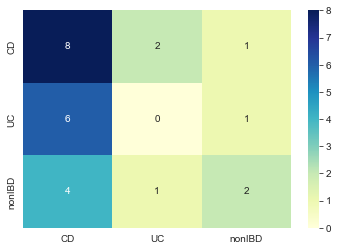

In [348]:
X_train, X_test, y_train, y_test, n_classes = n_samples_2_model(IBDMDB_Metaphlan4)

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=42)

RF_model.fit(X_train, y_train)
RF_predictions = RF_model.predict(X_test)
labels = np.unique(y_test)
cm_RF = confusion_matrix(y_test, RF_predictions,labels=labels)
cm_RF = pd.DataFrame(cm_RF, index=labels, columns=labels)
sns.heatmap(cm_RF, cmap="YlGnBu", annot=True)
print(round(metrics.accuracy_score(y_test, RF_predictions)*100,2))

In [287]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(RF_model)
shap_values = explainer.shap_values(X_importance)

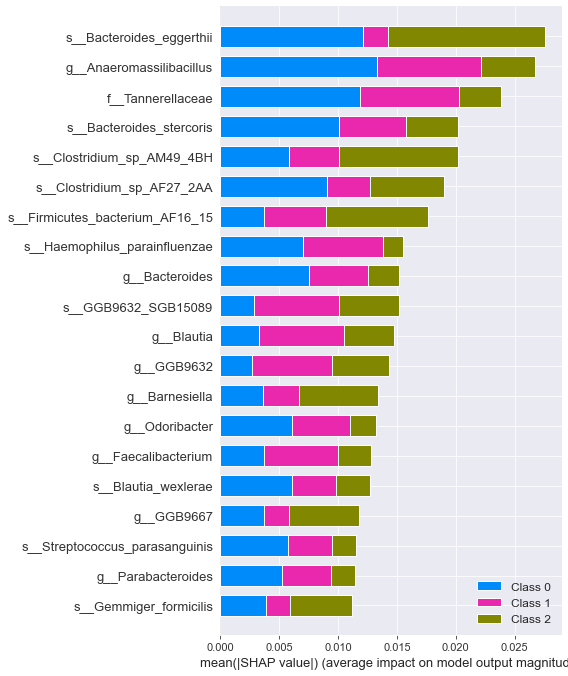

In [288]:
shap.summary_plot(shap_values, X_importance)

,Diagnosis,n_y_test
0.0,61,26
1.0,18,8


91.18


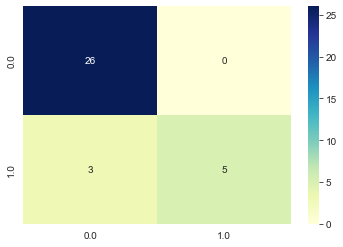

In [349]:
X_train, X_test, y_train, y_test, n_classes = n_samples_2_model(Lewis_metaphlan4)

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=42)

RF_model.fit(X_train, y_train)
RF_predictions = RF_model.predict(X_test)
labels = np.unique(y_test)
cm_RF = confusion_matrix(y_test, RF_predictions,labels=labels)
cm_RF = pd.DataFrame(cm_RF, index=labels, columns=labels)
sns.heatmap(cm_RF, cmap="YlGnBu", annot=True)
print(round(metrics.accuracy_score(y_test, RF_predictions)*100,2))

In [290]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(RF_model)
shap_values = explainer.shap_values(X_importance)

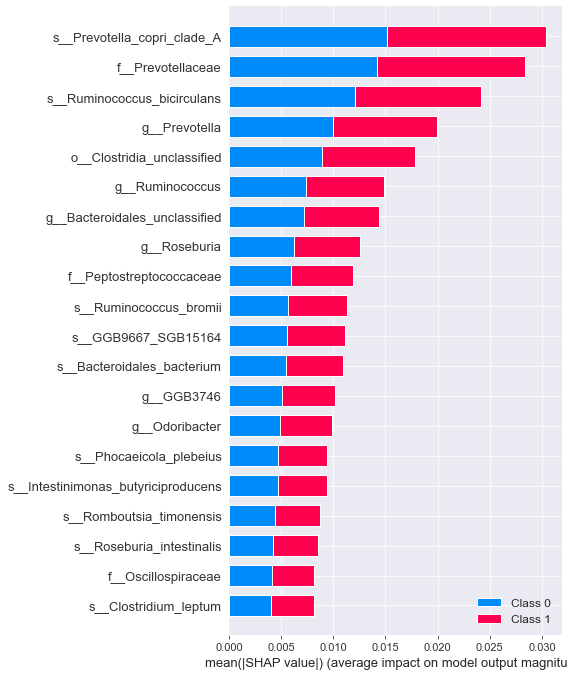

In [291]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)